Implementing an MLP

Paper this is based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Approach:
- we embed all 17,000 words in a 30-dimensional vector; these embeddings are put in a (17000, 30) lookup table C
- the embeddings are initialized randomly and then tuned with backprop (max. log likelihood of the training data); similar words / synonyms will be close together in the space
- input layer: we then take 3 words and aim to guess the next one
- hidden layer: can be as small / large as we like; every node in this layer would be connected to the 90 incoming numbers; uses tanh
- output layer: has 17,000 neurons to cover all the words; hence this is the expensive layer; uses a softmax
- optimization of the weights & biases of the output & hidden layer and the lookup table values
- finding a learning rate: you plot learning rates against losses and then see which is the largest learning rate that won't increase loss
- learning rate decay: if the large learning rate (lr) does not improve loss anymore, you can reduce the lr to get lower loss

TODO
- read torch broadcasting rules

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

In [ ]:
len(words)

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    #print(w)
    # create a list with zeros of len() = block_size
    context = [0] * block_size
    # go through every character in the ( word + '.')
    for ch in w + '.':
        # set ix to the index of the character e.g. a = 1
        ix = stoi[ch]
        # append the context list to X
        X.append(context)
        # append ix to Y
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
# go through this code!
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
C = torch.randn([27, 2])
C

In [ ]:
emb = C[X]
emb.shape

In [ ]:
# 6 because you have 3 elements in a 2-dimensional space; 100 neurons is a design choice and can be different
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
# you can change the shape of the vector with view
# also this operation is extremely efficient
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

In [ ]:
h.shape

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)    

In [ ]:
# that gives the next likely character (out of 27) for each of the 32 combinations we have
prob.shape

In [ ]:
# this gives the likelihood of the correct answer for each example; because it looks for the Y-th element (which are the correct answers)
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [ ]:
# -------------- now made more respectable :) --------------

In [159]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [160]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [161]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [162]:
for p in parameters:
    p.requires_grad = True

In [163]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [164]:
lri = []
lossi = []
stepi = []

In [165]:
for i in range(20000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    # lr = lrs[i]
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.1497514247894287


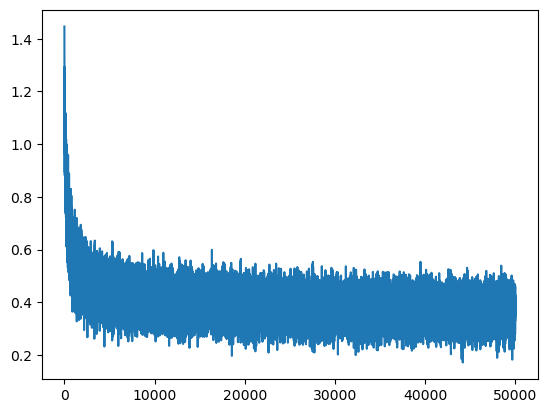

In [166]:
# you use the learning rate in the valley, because those are the largest learning rates that don't increase the loss 
# hence 10**-1 = 0.1 is a good learning rate
plt.plot(stepi, lossi)

In [167]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3418, grad_fn=<NllLossBackward0>)

In [168]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3654, grad_fn=<NllLossBackward0>)

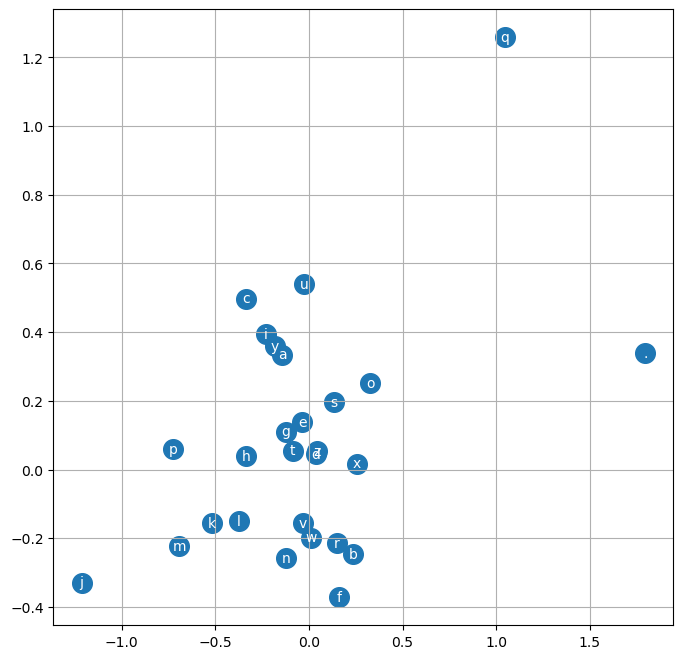

In [169]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
# training split, dev/validation split (used optimizing hyperparameters), test split (used to evaluate model at the end)
# 80%, 10%, 10%
